# 《合成孔径雷达成像——算法与实现》第5章 SAR信号的性质

# 点目标仿真

仿真参数如下：

|    参数类别 |名称       |记号|变量 |值|单位|
| :----------- | :---------   | :---- | :---- | :--|----|
|距离向参数   |景中心斜距|$R(\eta_c)$|R_eta_c|20|km|
|          |发射脉冲时宽|$T_r$| Tr| 25 |$\mu$s|                
|          |距离向调频率|$K_r$| Kr|0.25e+12|Hz/s|      
|          |距离信号带宽|$B_w$| Bw | $\|K_r\|T_r$|Hz|                         
|          |距离过采样率|$\alpha_{os,r}$| alpha_os_r|1.2 | |
|          |距离向采样率|$T_r$| Fr| $\alpha_{os,r}B_w$|Hz|                                  
|          |距离线采样点数|$T_r$| Nrg| 256 | |
|方位向参数   |等效雷达速度|$Vr$| Vr | 150 | m/s|
|          |电磁传播速度|$c$|c | 3e+8 | |             
|          |雷达工作频率|$f_0$|f0 | 5.3e+9 | |          
|          |雷达工作波长|$\lambda$|lambda  | | |                     
|          |多普勒带宽|$\Delta f _{dop}$|Delta_f_dop | 80 | |                 
|          |目标照射时间 |$T_a$|Ta | | |       
|          |方位向调频率|$K_a$|Ka  | | |    
|          |方位过采样率|$\alpha_{os,a}$|alpha_os_a | 1.3 | |
|          |方位向采样率|$F_a$|Fa | | |
|          |距离线数|$N_{az}$|Naz | 256| |
|          |波束斜视角|$Vr$|theta_sq_c | 0&+22.8 | |        
|          |波束中心穿越时刻|$Vr$|t_eta_c | 0&-51.7 | |        
|          |多普勒中心频率|$Vr$|f_eta_c | 0&2055 | | 

目标照射时间公式为：$T_a=0.886\frac{\lambda R(\eta_c)}{L_aV_g\cos\theta_{r,c}}$ ，方位向调频率公式为：$K_a=\frac{2V_r2\theta_{r,c}}{\lambda R(\eta_c)}$ 。雷达到目标的最短距离为：$R_0=R(\eta_c)\cos\theta_{r,c}$ ，雷达的方位向3dB波束宽度为：$\theta_{bw}=\frac{\lambda\Delta f_{dop}}{2V_s\cos\theta_{r,c}}=0.886\frac{\lambda}{L_a}$ ，则实际天线长度为： $L_a=0.886\frac{2V_s\cos\theta_{r,c}}{\Delta f_{dop}}$。

### 零斜视角情况

解调后单个点目标的基带信号：
$s_0(\tau,\eta)=A_0\omega_r\left(\tau-\frac{2R(\eta)}{c}\right)\omega_a(\eta-\eta_c)\exp\left\{ -j4\pi\frac{f_0R(\eta)}{c} \right\}\exp\left\{ j\pi K_r\left(\tau-\frac{2R(\eta)}{c}\right)^2 \right\}$

$T_a=0.886\frac{\lambda R(\eta_c)}{L_aV_g}$, $T_a=0.886\frac{\lambda R(\eta_c)}{L_aV_g}$。

$R(\eta)=R_0+\frac{V_r2}{2R_0}$ 

$\omega_r\left(\tau-\frac{2R(\eta)}{c}\right)=rect\left(\frac{\tau-2R(\eta)/c}{T_r}\right)$

$\omega_a(\eta-\eta_c)=sinc^2\left[0.886\frac{\theta_{r,c}}{\theta_{bw}}\right]=sinc^2\left[0.886\frac{\arctan(V_g(\eta-\eta_c)/R_0)}{\theta_{bw}}\right]$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体 
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

In [5]:
from numpy import sinc,cos,arctan,angle,pi,abs,ceil,sqrt,exp
from numpy.fft import fft,fft2

## 参数设置
#  已知参数--》距离向参数
R_eta_c = 20e+3;                # 景中心斜距
Tr = 25e-6;                     # 发射脉冲时宽
Kr = 0.25e+12;                  # 距离向调频率
alpha_os_r = 1.2;               # 距离过采样率
Nrg = 256;                      # 距离线采样点数
#  计算参数--》距离向参数
Bw = abs(Kr)*Tr;                # 距离信号带宽
Fr = alpha_os_r*Bw;             # 距离向采样率
#  已知参数--》方位向参数
c = 3e+8;                       # 电磁传播速度
Vr = 150;                       # 等效雷达速度
Vs = Vr;                        # 卫星平台速度
Vg = Vr;                        # 波束扫描速度
f0 = 5.3e+9;                    # 雷达工作频率
Delta_f_dop = 80;               # 多普勒带宽
alpha_os_a = 1.3;               # 方位过采样率
Naz = 256;                      # 距离线数
theta_r_c = np.array([0,+22.8]);          # 波束斜视角
t_eta_c = np.array([0,-51.7]);            # 波束中心穿越时刻
f_eta_c = np.array([0,+2055]);            # 多普勒中心频率
#  计算参数--》方位向参数
lambda0 = c/f0;                  # 雷达工作波长
Fa = alpha_os_a*Delta_f_dop;    # 方位向采样率
#  参数计算
R0 = R_eta_c*cos(theta_r_c[0]);                         # 最短斜距
La = 0.886*2*Vs*cos(theta_r_c[0])/Delta_f_dop;          # 实际天线长度
theta_bw = 0.886*lambda0/La;                             # 方位向3dB波束宽度
Trr = Nrg/Fr;                   # 发射脉冲时宽
Taa = Naz/Fa;                   # 目标照射时间
Ka = 2*Vr**2/lambda0/R0;          # 方位向调频率
d_t_tau = 1/Fr;                 # 距离采样时间间隔
d_t_eta = 1/Fa;                 # 方位采样时间间隔
d_f_tau = Fa/Nrg;               # 距离采样频率间隔    
d_f_eta = Fa/Naz;               # 方位采样频率间隔
## 变量设置
#  时间变量                                                    
t_tau = np.arange(-Trr/2,Trr/2,d_t_tau) + 2*R_eta_c/c;   # 距离时间变量
t_eta = np.arange(-Taa/2,Taa/2,d_t_eta) + t_eta_c[0];    # 方位时间变量
#  坐标设置                                                                                                             
t_tauX,t_eta_Y= np.meshgrid(t_tau,t_eta);               # 设置二维网络坐标
## 信号设置
R_eta = R0 + Vr**2*t_eta_Y**2/(2*R0);                    # 瞬时斜率
A0 = 1;                                                 # 后向散射系数幅度
wr = np.where(abs(t_tauX-2*R_eta/c) <= Tr/2,1,0);                   # 距离向包络
wa = sinc(0.886*arctan(Vg*(t_eta_Y-t_eta_c[0])/R0)/theta_bw)**2;      # 方位向包络

#  接收信号
srt   = A0*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2);                                                        
srt_z = A0*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2);# 正扫频
srt_f = A0*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(-1j*pi*Kr*(t_tauX-2*R_eta/c)**2);# 负扫频


根据$K_r$的符号，相位等值线或为双曲线，或为椭圆。假设信号为正扫频( $K_r>0$)，相位等值线为双曲线，如果信号为正扫频( $K_r<0$)，相位等值线为椭圆。

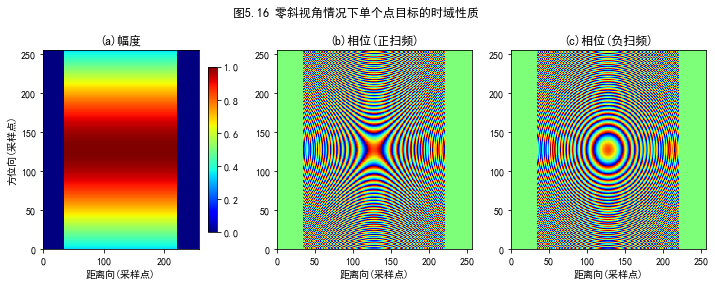

In [7]:
# 绘图
from matplotlib.pyplot import figure,subplot,plot,axis,title,xlabel,ylabel,text,arrow
eps = np.finfo(np.float64).eps
# 绘图      
figure(figsize=(10,4));
subplot(131)
c = plt.pcolor(abs(srt_z),cmap='jet')
plt.colorbar(shrink = .83)
xlabel('距离向(采样点)');ylabel('方位向(采样点)');title('(a)幅度');
subplot(132)
plt.pcolor(angle(srt_z+eps),cmap='jet')
xlabel('距离向(采样点)');title('(b)相位(正扫频)');
subplot(133)
# plt.pcolor(angle(srt_f))
plt.pcolor(angle(srt_f+eps),cmap='jet')
xlabel('距离向(采样点)');title('(c)相位(负扫频)');
plt.suptitle('图5.16 零斜视角情况下单个点目标的时域性质')
plt.tight_layout()


图5.16(b)和图5.16(c)中多出来的“鞍点”和“靶点”表明相位等值线存在虚像，这是因为缠绕状态的相位只代表复数信号的部分信息，故仅给出相位图就等价于将复数信号表示成实数信号，因而出现了虚像。

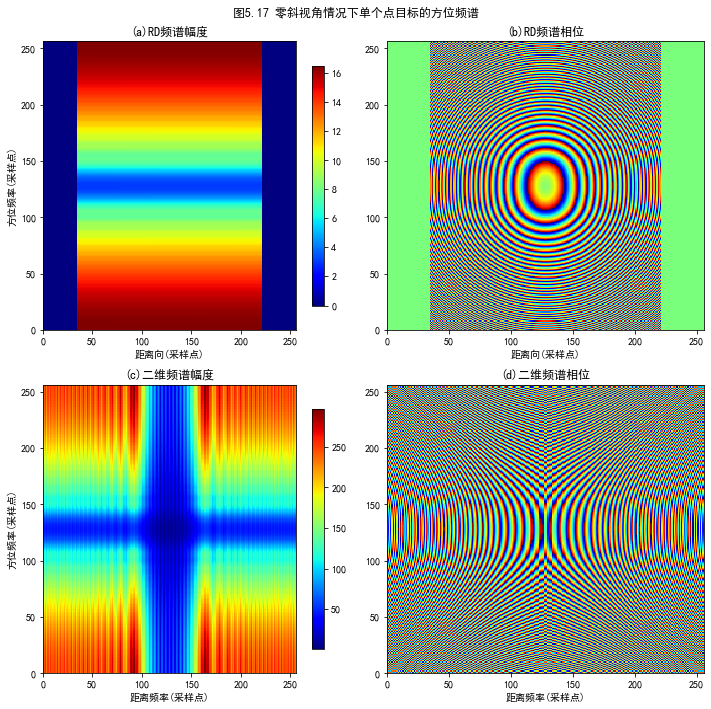

In [10]:
#  距离时域-方位频域
# from numpy import savetxt
# savetxt("srt.txt",np.abs(srt),delimiter=',')
Srf_rd = fft(srt,axis=0);

#  距离频域-方位频域
SrF_2d = fft2(srt);
figure(figsize=(10,10));

subplot(221)
plt.pcolor(abs(Srf_rd),cmap='jet')
plt.colorbar(shrink = .83)
xlabel('距离向(采样点)');ylabel('方位频率(采样点)');title('(a)RD频谱幅度');
subplot(222)
plt.pcolor(angle(Srf_rd+eps),cmap='jet')
xlabel('距离向(采样点)');title('(b)RD频谱相位');
#  距离频域-方位频域                  
subplot(223)
plt.pcolor(abs(SrF_2d),cmap='jet')
plt.colorbar(shrink = .83)
xlabel('距离频率(采样点)');ylabel('方位频率(采样点)');title('(c)二维频谱幅度');
subplot(224)
plt.pcolor(angle(SrF_2d+eps),cmap='jet')
xlabel('距离频率(采样点)');title('(d)二维频谱相位');
plt.suptitle('图5.17 零斜视角情况下单个点目标的方位频谱')
plt.tight_layout()

### 非零斜视角情况

解调后单个点目标的基带信号：

$s_0(\tau,\eta)=A_0\omega_r\left(\tau-\frac{2R(\eta)}{c}\right)\omega_a(\eta-\eta_c)\exp\left\{ -j4\pi\frac{f_0R(\eta)}{c} \right\}\exp\left\{ j\pi K_r\left(\tau-\frac{2R(\eta)}{c}\right)^2 \right\}$

$T_a=0.886\frac{\lambda R(\eta_c)}{L_aV_g}$, $K_a=\frac{2V_r^2\cos^2\theta_{r,c}}{\lambda R(\eta_c)}$。

$R(\eta)=\sqrt{R_0^2+V_r^2\eta^2}$ 

$\omega_r\left(\tau-\frac{2R(\eta)}{c}\right)=rect\left(\frac{\tau-2R(\eta)/c}{T_r}\right)$

$\omega_a(\eta-\eta_c)=sinc^2\left[0.886\frac{\theta_{r,c}}{\theta_{bw}}\right]=sinc^2\left[0.886\frac{\arctan(V_g(\eta-\eta_c)/R_0)}{\theta_{bw}}\right]$

In [11]:
## 参数设置
#  已知参数--》距离向参数
R_eta_c = 20e+3;                # 景中心斜距
Tr = 25e-6;                     # 发射脉冲时宽
Kr = 0.25e+12;                  # 距离向调频率
alpha_os_r = 1.2;               # 距离过采样率
Nrg = 256;                      # 距离线采样点数
#  计算参数--》距离向参数
Bw = abs(Kr)*Tr;                # 距离信号带宽
Fr = alpha_os_r*Bw;             # 距离向采样率
#  已知参数--》方位向参数
c = 3e+8;                       # 电磁传播速度
Vr = 150;                       # 等效雷达速度
Vs = Vr;                        # 卫星平台速度
Vg = Vr;                        # 波束扫描速度
f0 = 5.3e+9;                    # 雷达工作频率
Delta_f_dop = 80;               # 多普勒带宽
alpha_os_a = 1.3;               # 方位过采样率
Naz = 256;                      # 距离线数
theta_r_c = np.array([0,-22.8])*pi/180;          # 波束斜视角
t_eta_c =  np.array([0,-51.7]);            # 波束中心穿越时刻
f_eta_c =  np.array([0,+2055]);            # 多普勒中心频率
#  计算参数--》方位向参数
lambda0 = c/f0;                  # 雷达工作波长
Fa = alpha_os_a*Delta_f_dop;    # 方位向采样率
#  参数计算
R0 = R_eta_c*cos(theta_r_c[1]);                         # 最短斜距
La = 0.886*2*Vs*cos(theta_r_c[1])/Delta_f_dop;          # 实际天线长度
theta_bw = 0.886*lambda0/La;                             # 方位向3dB波束宽度
Trr = Nrg/Fr;                   # 发射脉冲时宽
Taa = Naz/Fa;                   # 目标照射时间
Ka = 2*Vr**2/lambda0/R0;          # 方位向调频率
d_t_tau = 1/Fr;                 # 距离采样时间间隔
d_t_eta = 1/Fa;                 # 方位采样时间间隔
d_f_tau = Fa/Nrg;               # 距离采样频率间隔    
d_f_eta = Fa/Naz;               # 方位采样频率间隔
## 变量设置
#  时间变量                                                    
t_tau = np.arange(-Trr/2,Trr/2,d_t_tau) + 2*R_eta_c/c;   # 距离时间变量
t_eta = np.arange(-Taa/2,Taa/2,d_t_eta) + t_eta_c[1];    # 方位时间变量
#  坐标设置                                                                                                             
t_tauX,t_eta_Y= np.meshgrid(t_tau,t_eta);               # 设置二维网络坐标
## 信号设置
R_eta = R0 + Vr**2*t_eta_Y**2/(2*R0);                    # 瞬时斜率
A0 = 1;                                                 # 后向散射系数幅度
wr = np.where(abs(t_tauX-2*R_eta/c) <= Tr/2,1,0);                   # 距离向包络
wa = sinc(0.886*arctan(Vg*(t_eta_Y-t_eta_c[1])/R0)/theta_bw)**2;      # 方位向包络
#  接收信号
srt = A0*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2);                                                        
srt_z = A0*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(+1j*pi*Kr*(t_tauX-2*R_eta/c)**2);# 正扫频
srt_f = A0*wr*wa*exp(-1j*4*pi*R0/lambda0)*exp(-1j*pi*Ka*t_eta_Y**2)*exp(-1j*pi*Kr*(t_tauX-2*R_eta/c)**2);# 负扫频
#  距离时域-方位频域
Srf_rd = fft(srt,axis=0);
#  距离频域-方位频域
SrF_2d = fft2(srt);

可见，在小斜视角情况下，总的距离徙动主要由二次分量构成；在大斜视角情况下，总的距离徙动主要由线性分量构成。

### 方位时域距离时域以及方位频域距离时域的目标轨迹

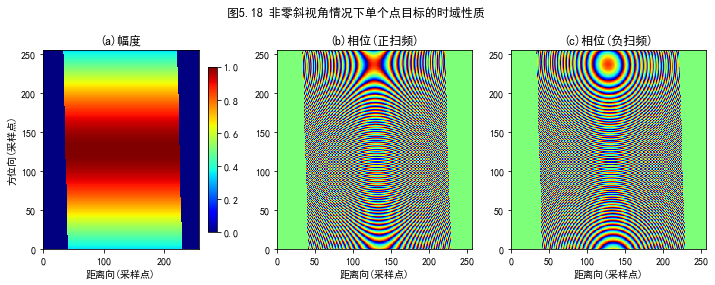

In [13]:
# 绘图
from matplotlib.pyplot import figure,subplot,plot,axis,title,xlabel,ylabel,text,arrow
eps = np.finfo(np.float64).eps
# 绘图      
figure(figsize=(10,4));
# fig, (ax0,ax1,ax2) = plt.subplots(1, 3)
subplot(131)
c = plt.pcolor(abs(srt_z),cmap='jet')
plt.colorbar(shrink = .83)
#imagesc(abs(srt_z)),colorbar               
xlabel('距离向(采样点)');ylabel('方位向(采样点)');title('(a)幅度');
subplot(132)
plt.pcolor(angle(srt_z+eps),cmap='jet')
xlabel('距离向(采样点)');title('(b)相位(正扫频)');
subplot(133)
plt.pcolor(angle(srt_f+eps),cmap='jet')
xlabel('距离向(采样点)');title('(c)相位(负扫频)');
plt.suptitle('图5.18 非零斜视角情况下单个点目标的时域性质')
plt.tight_layout()

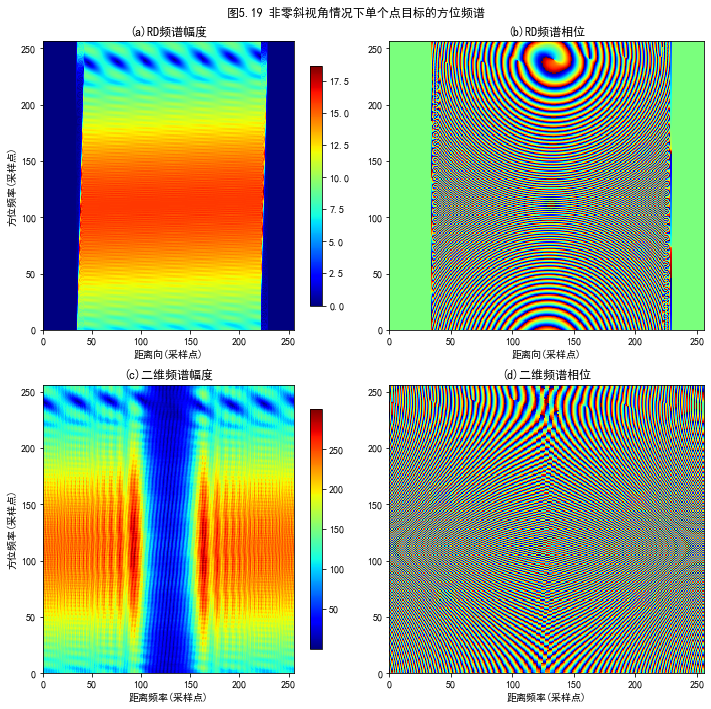

In [14]:
# 绘图
from matplotlib.pyplot import figure,subplot,plot,axis,title,xlabel,ylabel,text,arrow
eps = np.finfo(np.float64).eps
# 绘图      
figure(figsize=(10,10));

subplot(221)
plt.pcolor(abs(Srf_rd),cmap='jet')
plt.colorbar(shrink = .83)
xlabel('距离向(采样点)');ylabel('方位频率(采样点)');title('(a)RD频谱幅度');
subplot(222)
plt.pcolor(angle(Srf_rd+eps),cmap='jet')
xlabel('距离向(采样点)');title('(b)RD频谱相位');
#  距离频域-方位频域                  
subplot(223)
plt.pcolor(abs(SrF_2d),cmap='jet')
plt.colorbar(shrink = .83)
xlabel('距离频率(采样点)');ylabel('方位频率(采样点)');title('(c)二维频谱幅度');
subplot(224)
plt.pcolor(angle(SrF_2d+eps),cmap='jet')
xlabel('距离频率(采样点)');title('(d)二维频谱相位');
plt.suptitle('图5.19 非零斜视角情况下单个点目标的方位频谱')
plt.tight_layout()

由于多普勒中心的改变，方位频率的间隙位置产生了移动。

根据 $\Delta f_{dop}=0.886\frac{2V_s\cos\theta_{r,c}}{L_a}$，多普勒带宽按波束斜视角的余弦值被缩小，所以此处的间隙变大。

本文Python代码参照Matlab代码自：https://github.com/wanghs008/SAR-SignalProcessing